In [58]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import re
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
from PIL import Image
from tqdm import tqdm_notebook
from collections import Counter

In [59]:
images_directory = '/content/drive/MyDrive/Colab_Notebooks/Projects/Image_Captionning/DataSet/Images/'
captions_path = '/content/drive/MyDrive/Colab_Notebooks/Projects/Image_Captionning/DataSet/captions.txt'

In [60]:
def load_captions(file_path):
  with open(file_path , 'r') as f :
    captions = f.readlines()
    captions = [caption.lower() for caption in captions]
    return captions
captions = load_captions(captions_path)
captions

['1000092795.jpg , two young guys with shaggy hair look at their hands while hanging out in the yard.\n',
 '1000092795.jpg , white males are outside near many bushes.\n']

In [61]:
def tokenize_captions(captions):
  tokenizer = Tokenizer()
  tokenizer = tokenizer.fit_on_texts(captions)

  return tokenizer


In [62]:
def clean_text(text):
  text = re.sub(r'[^\w\s]' , '' , text)
  text = re.sub(r'\d+' , '' , text)
  text = re.sub(r'\s+' , ' ' , text).strip()

  return text

In [63]:
cleaned_captions = [clean_text(caption.split(',')[1]) for caption in captions]
cleaned_captions

['two young guys with shaggy hair look at their hands while hanging out in the yard',
 'white males are outside near many bushes']

In [64]:
captions_Ids = []
for i in range(len(cleaned_captions)):
  item = captions[i].split(',')[0].strip() + '\t' + 'start ' + cleaned_captions[i] + ' end\n'
  captions_Ids.append(item)
captions_Ids

['1000092795.jpg\tstart two young guys with shaggy hair look at their hands while hanging out in the yard end\n',
 '1000092795.jpg\tstart white males are outside near many bushes end\n']

In [65]:
def vocab_size_funct(text_list):
    mots_uniques = set()
    for phrase in text_list:
        mots = word_tokenize(phrase)
        mots_uniques.update(mots)
    return len(mots_uniques)
vocab_size = vocab_size_funct(cleaned_captions)
vocab_size

23

In [66]:
all_image_ids = os.listdir(images_directory)
all_image_ids
# list contien les noms des fichiers dans ce directory avec son extension

In [67]:
train_image_ids = all_image_ids

In [68]:
train_captions = []
for caption in captions_Ids:
  img_id  , _= caption.split('\t')
  if img_id in train_image_ids:
    train_captions.append(caption)

print('the captions : \n' , train_captions , '\nthe length : \n',len(train_captions))

the captions : 
 ['1000092795.jpg\tstart two young guys with shaggy hair look at their hands while hanging out in the yard end\n', '1000092795.jpg\tstart white males are outside near many bushes end\n'] 
the length : 
 2


# Extracting img features using InceptionV3

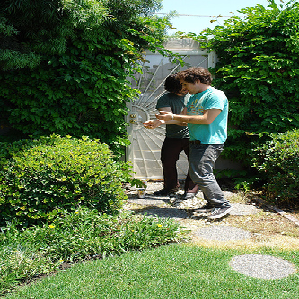

In [69]:
img_path = images_directory + '1000092795.jpg'
img  = load_img(img_path , target_size = (299 , 299))
img

In [70]:
img = img_to_array(img)
img

array([[[  0.,   6.,   4.],
        [  2.,   6.,   5.],
        [  3.,   5.,   4.],
        ...,
        [219., 244., 249.],
        [222., 253., 255.],
        [221., 249., 250.]],

       [[  3.,   3.,   3.],
        [  4.,   4.,   4.],
        [  5.,   5.,   5.],
        ...,
        [242., 255., 255.],
        [232., 255., 251.],
        [214., 245., 250.]],

       [[  2.,   4.,   3.],
        [  8.,  10.,   9.],
        [  6.,   6.,   6.],
        ...,
        [  8.,  65.,  12.],
        [ 39., 105.,  15.],
        [175., 239., 205.]],

       ...,

       [[ 72.,  98.,  50.],
        [112., 148.,  74.],
        [179., 180., 123.],
        ...,
        [186., 202., 166.],
        [157., 188., 118.],
        [176., 214., 153.]],

       [[166., 177., 147.],
        [180., 188., 131.],
        [130., 155., 100.],
        ...,
        [106., 158.,  86.],
        [134., 172., 113.],
        [107., 163.,  72.]],

       [[144., 157.,  87.],
        [185., 211., 172.],
        [184., 2

In [71]:
img.shape

(299, 299, 3)

In [72]:
img = np.expand_dims(img , axis = 0)
img.shape
# la premiere dim ajouté represente qu'un batch contenant une seule image

(1, 299, 299, 3)

In [73]:
img

array([[[[  0.,   6.,   4.],
         [  2.,   6.,   5.],
         [  3.,   5.,   4.],
         ...,
         [219., 244., 249.],
         [222., 253., 255.],
         [221., 249., 250.]],

        [[  3.,   3.,   3.],
         [  4.,   4.,   4.],
         [  5.,   5.,   5.],
         ...,
         [242., 255., 255.],
         [232., 255., 251.],
         [214., 245., 250.]],

        [[  2.,   4.,   3.],
         [  8.,  10.,   9.],
         [  6.,   6.,   6.],
         ...,
         [  8.,  65.,  12.],
         [ 39., 105.,  15.],
         [175., 239., 205.]],

        ...,

        [[ 72.,  98.,  50.],
         [112., 148.,  74.],
         [179., 180., 123.],
         ...,
         [186., 202., 166.],
         [157., 188., 118.],
         [176., 214., 153.]],

        [[166., 177., 147.],
         [180., 188., 131.],
         [130., 155., 100.],
         ...,
         [106., 158.,  86.],
         [134., 172., 113.],
         [107., 163.,  72.]],

        [[144., 157.,  87.],
       

In [74]:
img = tf.keras.applications.inception_v3.preprocess_input(img)

In [75]:
img

array([[[[-1.        , -0.9529412 , -0.96862745],
         [-0.9843137 , -0.9529412 , -0.9607843 ],
         [-0.9764706 , -0.9607843 , -0.96862745],
         ...,
         [ 0.7176471 ,  0.9137255 ,  0.9529412 ],
         [ 0.7411765 ,  0.9843137 ,  1.        ],
         [ 0.73333335,  0.9529412 ,  0.9607843 ]],

        [[-0.9764706 , -0.9764706 , -0.9764706 ],
         [-0.96862745, -0.96862745, -0.96862745],
         [-0.9607843 , -0.9607843 , -0.9607843 ],
         ...,
         [ 0.8980392 ,  1.        ,  1.        ],
         [ 0.81960785,  1.        ,  0.96862745],
         [ 0.6784314 ,  0.92156863,  0.9607843 ]],

        [[-0.9843137 , -0.96862745, -0.9764706 ],
         [-0.9372549 , -0.92156863, -0.92941177],
         [-0.9529412 , -0.9529412 , -0.9529412 ],
         ...,
         [-0.9372549 , -0.49019605, -0.90588236],
         [-0.69411767, -0.17647058, -0.88235295],
         [ 0.37254906,  0.8745098 ,  0.60784316]],

        ...,

        [[-0.4352941 , -0.23137254, -0

In [76]:
img.shape

(1, 299, 299, 3)

In [77]:
InceptionV3_model = InceptionV3(weights  = 'imagenet' , input_shape= (299 , 299 , 3))

In [78]:
InceptionV3_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 149, 149, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 149, 149, 32)         0         ['batch_normalizati

In [79]:
# delete the last layer
InceptionV3_model.layers.pop()

In [80]:
InceptionV3_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 149, 149, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 149, 149, 32)         0         ['batch_normalizati

In [81]:
InceptionV3_model = Model(inputs=InceptionV3_model.inputs, outputs=InceptionV3_model.layers[-2].output)

In [82]:

InceptionV3_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 149, 149, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 149, 149, 32)         0         ['batch_normalization_94

In [83]:
img_features = InceptionV3_model.predict(img, verbose=False)
img_features

array([[0.18245932, 0.16290455, 0.5226525 , ..., 0.676896  , 0.32863927,
        0.08636475]], dtype=float32)

In [84]:
img_features.shape

(1, 2048)

In [85]:
len(img_features[0])
#(None , 2048) La deuxième dimension, 2048, indique le nombre de neurones dans la couche avant-dernière.

2048

In [86]:
img_features.flatten()

array([0.18245932, 0.16290455, 0.5226525 , ..., 0.676896  , 0.32863927,
       0.08636475], dtype=float32)

In [87]:
all_image_ids

['1000092795.jpg']

In [88]:
train_img_features = {}
img_id = captions_Ids[0].split('\t')[0]
train_img_features[img_id] = img_features.flatten()

In [89]:
train_img_features

{'1000092795.jpg': array([0.18245932, 0.16290455, 0.5226525 , ..., 0.676896  , 0.32863927,
        0.08636475], dtype=float32)}

In [90]:
train_captions

['1000092795.jpg\tstart two young guys with shaggy hair look at their hands while hanging out in the yard end\n',
 '1000092795.jpg\tstart white males are outside near many bushes end\n']

In [153]:
train_captions = ['1000092795.jpg\tstart two young guys with shaggy hair look at their hands while hanging out in the yard end\n',
 '1000092794.jpg\tstart white males are outside near many bushes end\n']

In [154]:
train_captions

['1000092795.jpg\tstart two young guys with shaggy hair look at their hands while hanging out in the yard end\n',
 '1000092794.jpg\tstart white males are outside near many bushes end\n']

In [155]:
train_img_features = {'1000092795.jpg': train_img_features['1000092795.jpg'] , '1000092794.jpg': train_img_features['1000092795.jpg']}

In [156]:
train_img_features

{'1000092795.jpg': array([0.18245932, 0.16290455, 0.5226525 , ..., 0.676896  , 0.32863927,
        0.08636475], dtype=float32),
 '1000092794.jpg': array([0.18245932, 0.16290455, 0.5226525 , ..., 0.676896  , 0.32863927,
        0.08636475], dtype=float32)}

In [92]:
cleaned_captions

['two young guys with shaggy hair look at their hands while hanging out in the yard',
 'white males are outside near many bushes']

In [93]:
tokenizer = tokenize_captions(cleaned_captions[0])

In [94]:
max_caption_length = max([len(caption.split()) for caption in cleaned_captions]) + 1
max_caption_length

17

In [95]:
batch_size = 270

In [96]:
img_id , caption_text = train_captions[0].split('\t')
img_id

'1000092795.jpg'

In [97]:
caption_text

'start two young guys with shaggy hair look at their hands while hanging out in the yard end\n'

In [98]:
caption_text = caption_text.strip('\n')

In [99]:
caption_text

'start two young guys with shaggy hair look at their hands while hanging out in the yard end'

In [100]:
tokenizer = Tokenizer()

# Donner au Tokenizer le texte pour apprendre le vocabulaire


tokenizer.fit_on_texts(['text caption text test'])
seq = tokenizer.texts_to_sequences(['text caption text test'])[0]

NameError: name 'Tokenizer' is not defined

In [101]:
seq

[1, 2, 1, 3]

In [157]:
image_id = '1000092795.jpg'
X_images , X_captions , y = [] , [] , []
for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i] # X_caption, Y
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X_images.append(train_img_features[image_id])
                    X_captions.append(in_seq)
                    y.append(out_seq)
y

[array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], dtype=float32)]

In [103]:
in_seq, out_seq = seq[:2], seq[2]
print(in_seq , ' ' ,out_seq)

[1, 2]   1


In [104]:
in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]
in_seq

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2], dtype=int32)

In [105]:
out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
out_seq

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)

In [106]:
t = to_categorical([4], num_classes=10)[0]
t

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

In [107]:
X_images, X_captions, y = [], [], []

In [108]:
X_images.append(train_img_features[img_id])
X_images

[array([0.18245932, 0.16290455, 0.5226525 , ..., 0.676896  , 0.32863927,
        0.08636475], dtype=float32)]

In [109]:
X_captions.append(in_seq)
X_captions

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2], dtype=int32)]

In [110]:
 y.append(out_seq)
 y

[array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], dtype=float32)]

In [122]:
def data_generator(X_images , X_captions , y):
  yield [np.array(X_images), np.array(X_captions)], np.array(y)

In [123]:
train_data_generator = data_generator(X_images , X_captions , y)

In [113]:
sample_batch = next(train_data_generator)
sample_batch
# en utilisant next pour extrayer successivement les batch

([array([[0.18245932, 0.16290455, 0.5226525 , ..., 0.676896  , 0.32863927,
          0.08636475]], dtype=float32),
  array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2]], dtype=int32)],
 array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.]], dtype=float32))

In [114]:
print("Training sample batch shapes:")
print("X_images:", sample_batch[0][0].shape)
print("X_captions:", sample_batch[0][1].shape)
print("y:", sample_batch[1].shape)

Training sample batch shapes:
X_images: (1, 2048)
X_captions: (1, 17)
y: (1, 23)


In [158]:
def data_gene_test(train_captions = train_captions , train_img_features = train_img_features):
                for caption in train_captions :
                    image_id, caption_text = caption.split('\t')
                    caption_text = caption_text.rstrip('\n')
                    seq = tokenizer.texts_to_sequences([caption_text])[0] # Tokenizing the caption
                    for i in range(1, len(seq)):
                        in_seq, out_seq = seq[:i], seq[i] # X_caption, Y
                        in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]
                        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                        X_images.append(train_img_features[image_id])
                        X_captions.append(in_seq)
                        y.append(out_seq)

                yield [np.array(X_images), np.array(X_captions)], np.array(y)

In [159]:
generated_data = data_gene_test(train_captions , train_img_features)

In [160]:
next(generated_data)

([array([[0.18245932, 0.16290455, 0.5226525 , ..., 0.676896  , 0.32863927,
          0.08636475],
         [0.18245932, 0.16290455, 0.5226525 , ..., 0.676896  , 0.32863927,
          0.08636475],
         [0.18245932, 0.16290455, 0.5226525 , ..., 0.676896  , 0.32863927,
          0.08636475]], dtype=float32),
  array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1]], dtype=int32)],
 array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.]], dtype=float32))

In [ ]:
# La philosophie de ce code est d'optimiser l'utilisation de la mémoire en générant les données à la volée au lieu de les stocker en mémoire.
# Cela est particulièrement important lorsque le jeu de données est volumineux et que toutes les données ne peuvent pas être chargées en mémoire en une seule fois.
# En utilisant un générateur, les données sont générées au fur et à mesure de leur demande,
# ce qui permet d'économiser de la mémoire et de garantir une utilisation efficace des ressources lors de l'entraînement du modèle.